<a href="https://colab.research.google.com/github/ItayShalit/Intro-to-Deep-Learning/blob/main/NNRegression_Intro_to_DL_Assignment3_Itay_Shalit_and_Erez_Cohen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Itay Shalit 207435199  
             Erez Cohen 208848531

In [1]:
!pip install pyhessian
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pyhessian import hessian
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_regression
from google.colab import files
from math import pi, acos
from sklearn.metrics import mean_squared_error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data Generation

In [2]:
RANDOM_STATE = 10
x,y = make_regression(100000, 10, random_state = RANDOM_STATE, noise = 0.1)
df = pd.DataFrame(x)
df['y'] = y
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

#Part 2

In [ ]:
batch_size = len(train)

test_target = torch.tensor(test['y'].values.astype(np.float32))#
test_target = torch.unsqueeze(test_target, dim = 1)
train_target = torch.tensor(train['y'].values.astype(np.float32))
train_target = torch.unsqueeze(train_target, dim = 1)
test = torch.tensor(test.drop('y', axis = 1).values.astype(np.float32))
train = torch.tensor(train.drop('y', axis = 1).values.astype(np.float32))

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        print(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

def calculate_gradient_l2_norm(model):
    mean_l2_norm = 0
    grad_num = 0
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        grad_num += len(p)
    for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        mean_l2_norm += (p.grad.data.norm(2).item())*(len(p)/grad_num)
    return mean_l2_norm

def init_weights_normal(model, init_std):
  for m in model.modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight, mean=0.0, std=init_std)
      if m.bias is not None:
        torch.nn.init.normal_(m.bias, mean=0.0, std=init_std)

class linearRegression(torch.nn.Module):
    def __init__(self, depth, inputSize, outputSize, hiddenSize):
        super(linearRegression, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(torch.nn.Linear(inputSize, hiddenSize))
        for i in range(depth-1):
          self.layers.append(torch.nn.Linear(hiddenSize, hiddenSize))
        self.layers.append(torch.nn.Linear(hiddenSize, outputSize))

    def forward(self, inx):
        x = inx
        for layer in self.layers:
          x = layer(x)
        return x


In [ ]:

HIDDEN_SIZE = 16
PLOTTING_PARAM = 100


epochs = 2000    
mseloss = F.mse_loss
lr = 10e-7
init_std = 10e-1

PLOTTING_PARAM = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target

all_loss_values, all_loss_grad_l2_norm, all_min_eigenvalues_of_hessian, all_max_eigenvalues_of_hessian  = [], [], [], []    


for depth in [2,3,4]:
  torch.cuda.empty_cache()
  test = test_cpu.to(device)
  train = train_cpu.to(device)
  test_target = test_target_cpu.to(device)
  train_target = train_target_cpu.to(device)
  loss_values, loss_grad_l2_norm, min_eigenvalues_of_hessian, max_eigenvalues_of_hessian  = [], [], [], []    
  model = linearRegression(depth, 10, 1, 16)    
  model = model.to(device) 
  init_weights_normal(model, init_std)
  for epoch in range(epochs):
      loss_values.append(mseloss(test_target, model(test)))
      loss_grad_l2_norm.append(calculate_gradient_l2_norm(model))  
      model.train()
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
      optimizer.zero_grad()
      loss = mseloss(train_target, model(train))  
      loss.backward()
      optimizer.step()
      if epoch%PLOTTING_PARAM == 0:
        print(f'epoch {epoch}, loss {loss_values[-1]}, train loss {mseloss(train_target, model(train))}, gradient norm {loss_grad_l2_norm[-1]}')   
        hessian_comp = hessian(model, F.mse_loss, data=(train, train_target), cuda=True)
        top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=15)
        min_eigenvalues_of_hessian.append(min(top_eigenvalues))
        max_eigenvalues_of_hessian.append(max(top_eigenvalues)) 
  all_loss_values.append(loss_values) 
  all_loss_grad_l2_norm.append(loss_grad_l2_norm) 
  all_min_eigenvalues_of_hessian.append(min_eigenvalues_of_hessian) 
  all_max_eigenvalues_of_hessian.append(max_eigenvalues_of_hessian)        

In [ ]:
fig = plt.figure(figsize = (18, 25))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot([i for i in range(len(all_loss_values[0]))], all_loss_values[0], label = 'Depth 2')
ax1.plot([i for i in range(len(all_loss_values[1]))], all_loss_values[1], label = 'Depth 3')
ax1.plot([i for i in range(len(all_loss_values[2]))], all_loss_values[2], label = 'Depth 4')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Loss')
ax1.set_title('Test Loss through Training')
ax1.legend()

ax2.plot([i for i in range(len(all_loss_grad_l2_norm[0]))], all_loss_grad_l2_norm[0], label = 'Depth 2')
ax2.plot([i for i in range(len(all_loss_grad_l2_norm[1]))], all_loss_grad_l2_norm[1], label = 'Depth 3')
ax2.plot([i for i in range(len(all_loss_grad_l2_norm[2]))], all_loss_grad_l2_norm[2], label = 'Depth 4')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('L2-Norm of Gradient')
ax2.set_title('Norm of Gradient through Training')
ax2.legend()

ax3.plot([i for i in range(len(all_min_eigenvalues_of_hessian[0]))], all_min_eigenvalues_of_hessian[0], label = 'Depth 2 Min Eigenvalue')
ax3.plot([i for i in range(len(all_min_eigenvalues_of_hessian[1]))], all_min_eigenvalues_of_hessian[1], label = 'Depth 3 Min Eigenvalue')
ax3.plot([i for i in range(len(all_min_eigenvalues_of_hessian[2]))], all_min_eigenvalues_of_hessian[2],label = 'Depth 4 Min Eigenvalue')
ax3.plot([i for i in range(len(all_max_eigenvalues_of_hessian[0]))], all_max_eigenvalues_of_hessian[0], label = 'Depth 2 Max Eigenvalue')
ax3.plot([i for i in range(len(all_max_eigenvalues_of_hessian[1]))], all_max_eigenvalues_of_hessian[1], label = 'Depth 3 Max Eigenvalue')
ax3.plot([i for i in range(len(all_max_eigenvalues_of_hessian[2]))], all_max_eigenvalues_of_hessian[2], label = 'Depth 4 Max Eigenvalue')
ax3.set_xlabel('Epoch')
ax3.set_title('Minimal and Maximal Eigenvalues of Hessian through Training')
ax3.legend()

# Part 3

In [ ]:
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

x_train = np.array(train.drop('y', axis = 1))
x_test = np.array(test.drop('y', axis = 1))
y_train = np.array(train['y'])
y_test = np.array(test['y'])

inputSize = 10
lr = 10e-7
epochs = 10000

In [ ]:
all_loss_values_part3 = []


for N in [2,3]:
  loss_values = []
  w = np.random.normal(0, 10e-1, 10).reshape(-1,1)
  for t in range(epochs):  
    loss_grad = (np.dot(np.transpose(x_train), np.dot(x_train,w) - y_train.reshape(-1,1)))*(2/(x_train.size))
    loss_values.append(mean_squared_error(y_test, np.dot(x_test,w)))
    update = np.zeros(w.shape)
    u1, s1, v1 = np.linalg.svd(np.dot(w.reshape(-1,1), np.transpose(w.reshape(-1,1))))
    u2, s2, v2 = np.linalg.svd(np.dot(np.transpose(w.reshape(-1,1)), w.reshape(-1,1)))
    for j in (1, N+1):
      s1_exp = np.power(s1, (j-1)/N) 
      s2_exp = np.power(s2, (N-j)/N)
      e1 = np.linalg.multi_dot([u1, np.diag(s1_exp), np.transpose(u1)])
      e2 = np.linalg.multi_dot([v2, np.diag(s2_exp), np.transpose(v2)])
      update += np.linalg.multi_dot([e1, loss_grad.reshape(-1,1), e2])
    w = w - lr*update
  all_loss_values_part3.append(loss_values)

In [ ]:
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1)
ax.plot([i for i in range(len(all_loss_values_part3[0][:2500]))], all_loss_values_part3[0][:2500], label = 'Discrete Updates with Formula N=2')
ax.plot([i for i in range(len(all_loss_values_part3[1][:2500]))], all_loss_values_part3[1][:2500], label = 'Discrete Updates with Formula N=3')
ax.plot([i for i in range(len(all_loss_values[0]))], all_loss_values[0], label = 'GD with Linear Network N=2')
ax.plot([i for i in range(len(all_loss_values[1]))], all_loss_values[1], label = 'GD with Linear Network N=3')
ax.legend()


# Part 4

In [3]:
RANDOM_STATE = 10

x,y = make_regression(1000, 10, random_state = RANDOM_STATE, noise = 0.1) #We use a smaller dataset here for computational reasons.
df = pd.DataFrame(x)
df['y'] = y

train, test = train_test_split(df, test_size = 0.25, random_state = 10)
batch_size = len(train)
test_target = torch.tensor(test['y'].values.astype(np.float32))#
test_target = torch.unsqueeze(test_target, dim = 1)
train_target = torch.tensor(train['y'].values.astype(np.float32))
train_target = torch.unsqueeze(train_target, dim = 1)
test = torch.tensor(test.drop('y', axis = 1).values.astype(np.float32))
train = torch.tensor(train.drop('y', axis = 1).values.astype(np.float32))

train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [4]:
class TangentKernelNet(torch.nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(TangentKernelNet, self).__init__()
        self.input_layer = torch.nn.Linear(inputSize, hiddenSize)
        torch.nn.init.normal_(self.input_layer.weight, mean = 0.0, std = 1.0)
        self.relu = nn.ReLU()
        self.output_layer = torch.nn.Linear(hiddenSize, 1)
        w = np.ones(hiddenSize)
        w[:int(hiddenSize*0.5)] = -1.
        np.random.shuffle(w)
        self.output_layer.weight = nn.Parameter(torch.tensor(w).type(torch.FloatTensor).reshape(1,-1))

    def forward(self, inx):
        x = self.input_layer(inx)
        x = self.relu(x)
        x = self.output_layer(x)
        return x


epochs = 15000   


mseloss = F.mse_loss
lr = 10e-7
init_std = 10e-1

PLOTTING_PARAM = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

test_cpu = test
train_cpu = train
test_target_cpu = test_target
train_target_cpu = train_target

all_loss_values = []

widths = [4, 32, 128, 512]

for width in widths:
  torch.cuda.empty_cache()
  test = test_cpu.to(device)
  train = train_cpu.to(device)
  test_target = test_target_cpu.to(device)
  train_target = train_target_cpu.to(device)
  loss_values =  []    
  model = TangentKernelNet(10, width)
  model = model.to(device) 
  for epoch in range(epochs):
      loss_values.append(mseloss(test_target, model(test)))
      model.train()
      # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
      optimizer = torch.optim.SGD(model.input_layer.parameters(), lr=lr, momentum=0) #We only update the parameters of the input layer.

      optimizer.zero_grad()
      loss = mseloss(train_target, model(train))  
      loss.backward()
      optimizer.step()
      if epoch%PLOTTING_PARAM == 0:
        print(f'epoch {epoch}, loss {loss_values[-1]}')   
  all_loss_values.append(loss_values)

Using cuda device
epoch 0, loss 46548.453125
epoch 200, loss 46514.42578125
epoch 400, loss 46480.109375
epoch 600, loss 46444.9140625
epoch 800, loss 46408.94140625
epoch 1000, loss 46372.06640625
epoch 1200, loss 46334.72265625
epoch 1400, loss 46296.69140625
epoch 1600, loss 46258.14453125
epoch 1800, loss 46219.37890625
epoch 2000, loss 46179.8828125
epoch 2200, loss 46139.296875
epoch 2400, loss 46098.37109375
epoch 2600, loss 46057.11328125
epoch 2800, loss 46015.75390625
epoch 3000, loss 45974.37890625
epoch 3200, loss 45932.73828125
epoch 3400, loss 45890.70703125
epoch 3600, loss 45848.51171875
epoch 3800, loss 45805.91015625
epoch 4000, loss 45763.17578125
epoch 4200, loss 45720.484375
epoch 4400, loss 45677.89453125
epoch 4600, loss 45635.35546875
epoch 4800, loss 45592.625
epoch 5000, loss 45549.890625
epoch 5200, loss 45506.99609375
epoch 5400, loss 45464.2109375
epoch 5600, loss 45421.75
epoch 5800, loss 45379.171875
epoch 6000, loss 45336.3046875
epoch 6200, loss 45293.2

In [5]:
train, test = train_test_split(df, test_size = 0.25, random_state = 10)

test_target = np.array(test['y'].values.astype(np.float32))#
test_target = np.array(test_target).reshape(-1,1)
train_target = np.array(train['y'].values.astype(np.float32))
train_target = np.array(train_target).reshape(-1,1)
test = np.array(test.drop('y', axis = 1).values.astype(np.float32)).transpose()
train = np.array(train.drop('y', axis = 1).values.astype(np.float32)).transpose()

np.random.RandomState(seed=RANDOM_STATE)


u = np.random.normal(loc=0.0, scale=0.001, size=train.shape[1]).reshape(train.shape[1], 1)
lr = 10e-7
epochs = 1500

gram = np.dot(train.transpose(), train)
norms = np.linalg.norm(train, axis = 0 , ord= 2).reshape(-1,1)
norm_products = np.dot(norms, norms.transpose())
quotient = np.divide(gram, norm_products)
quotient[quotient > 1] = 1.0 #Fixing a problem caused by numerical inaccuracies.
h_star = np.dot(gram,(pi - np.arccos(quotient)))/(2*pi)

analytic_loss_values = []

for i in range(epochs):
  analytic_loss_values.append(np.linalg.norm(train_target - u, ord = 2))
  u_grad = -np.dot(h_star, u - train_target)
  u = u + (u_grad*lr)
  if i%15 == 0:
    print(f"epoch: {i}, loss: {analytic_loss_values[-1]}")


epoch: 0, loss: 5451.271908072592
epoch: 15, loss: 4781.905315332305
epoch: 30, loss: 4199.953176243057
epoch: 45, loss: 3693.3426805063145
epoch: 60, loss: 3251.743418220461
epoch: 75, loss: 2866.3085030739016
epoch: 90, loss: 2529.454740202946
epoch: 105, loss: 2234.6759185175733
epoch: 120, loss: 1976.3842068642464
epoch: 135, loss: 1749.7753954649017
epoch: 150, loss: 1550.714369929138
epoch: 165, loss: 1375.6377527335273
epoch: 180, loss: 1221.4711115325235
epoch: 195, loss: 1085.5585277682287
epoch: 210, loss: 965.6026535388419
epoch: 225, loss: 859.6136686426514
epoch: 240, loss: 765.8657907972515
epoch: 255, loss: 682.8601967170373
epoch: 270, loss: 609.2933854949855
epoch: 285, loss: 544.0301632197732
epoch: 300, loss: 486.0805529056579
epoch: 315, loss: 434.5800399669258
epoch: 330, loss: 388.7726534775699
epoch: 345, loss: 347.99645974330053
epoch: 360, loss: 311.67110934100026
epoch: 375, loss: 279.28713350895043
epoch: 390, loss: 250.39673209804513
epoch: 405, loss: 224.60

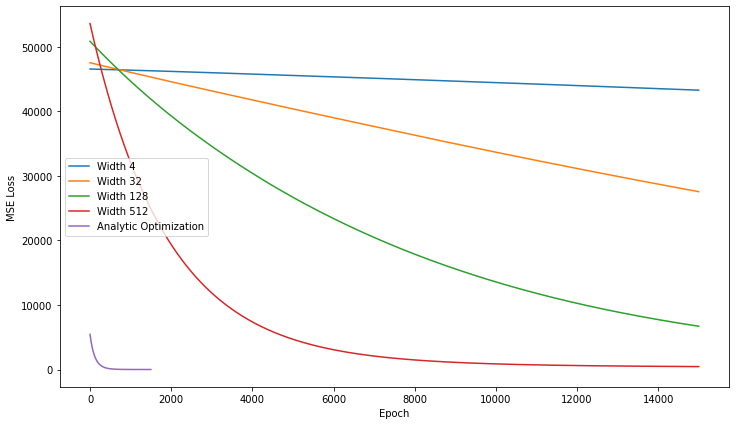

In [6]:
for i in range(len(all_loss_values)):
  all_loss_values[i] = torch.tensor(all_loss_values[i]).cpu()
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1)
ax.plot([i for i in range(len(all_loss_values[0]))], all_loss_values[0], label = 'Width 4')
ax.plot([i for i in range(len(all_loss_values[1]))], all_loss_values[1], label = 'Width 32')
ax.plot([i for i in range(len(all_loss_values[2]))], all_loss_values[2], label = 'Width 128')
ax.plot([i for i in range(len(all_loss_values[3]))], all_loss_values[3], label = 'Width 512')
ax.plot([i for i in range(len(analytic_loss_values))], analytic_loss_values, label = 'Analytic Optimization')

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
